In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(33, 24)

In [6]:
df_states.shape

(1765, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-01,56,210816,939190,59669,16223.0,31142.0,3837.0,4270.0,71.0,...,4700,31142.0,1209675,1150006,1150006,954.0,4482.0,74989.0,26133.0,101122.0
3,2020-04-02,56,239099,1028649,62101,17157.0,32649.0,4264.0,541.0,67.0,...,5784,32649.0,1329849,1267748,1267748,1084.0,1507.0,89459.0,28283.0,117742.0
2,2020-04-03,56,271988,1124874,61980,19926.0,35991.0,4686.0,593.0,70.0,...,6962,35991.0,1458842,1396862,1396862,1178.0,3342.0,96225.0,32889.0,129114.0
1,2020-04-04,56,305755,1318052,15573,22158.0,38402.0,5207.0,691.0,656.0,...,8314,38402.0,1639380,1623807,1623807,1352.0,2411.0,193178.0,33767.0,226945.0
0,2020-04-05,56,332308,1429724,17307,23061.0,41372.0,5497.0,913.0,612.0,...,9498,41372.0,1779339,1762032,1762032,1184.0,2970.0,111672.0,26553.0,138225.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-06,NE,409.0,6378.0,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,6795,6787,6787,31,0.0,0.0,820.0,46.0,866.0
31,2020-04-06,ND,225.0,6988.0,NaN,19.0,32.0,NaN,NaN,NaN,...,32.0,7213,7213,7213,38,0.0,1.0,408.0,18.0,426.0
30,2020-04-06,NC,2870.0,37856.0,NaN,270.0,NaN,NaN,NaN,NaN,...,NaN,40726,40726,40726,37,2.0,0.0,396.0,285.0,681.0
28,2020-04-06,MS,1738.0,18632.0,NaN,NaN,475.0,NaN,NaN,NaN,...,475.0,20370,20370,20370,28,8.0,0.0,13052.0,100.0,13152.0
0,2020-04-06,AK,191.0,6692.0,NaN,NaN,23.0,NaN,NaN,NaN,...,23.0,6883,6883,6883,2,0.0,3.0,593.0,6.0,599.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per million
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e6)

# Calculate hospitalized per million
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e6)

# Calculate deaths per million
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e6)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per million people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e6)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
1672,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1673,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
1674,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1675,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1676,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,1677.000000,1572.000000,457.000000,144.000000,515.000000,44.000000,80.000000,44.000000,50.000000,173.000000,...,1625.000000,1677.000000,1.677000e+03,1655.000000,1677.000000,515.000000,1020.000000,1567.000000,1572.000000,712.000000
mean,1654.302326,8262.697837,1569.126915,1279.854167,681.881553,1004.613636,289.275000,111.954545,106.580000,515.248555,...,1178.473231,29.549791,6.515411e+06,428.912278,191.507621,63.011079,7.116765,0.125892,1736.078329,52.340088
std,7882.032333,17787.092845,8747.550061,3343.648771,2935.151638,1349.417363,610.500292,245.884635,149.871658,1917.105010,...,3163.226112,16.340739,7.349534e+06,1599.635149,508.376013,152.342471,17.993902,0.138720,2465.687596,201.488807
min,0.000000,0.000000,-3.000000,2.000000,0.000000,9.000000,6.000000,4.000000,4.000000,2.000000,...,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,134.500000,4.000000,41.000000,27.000000,26.750000,14.000000,6.000000,14.000000,26.000000,...,20.000000,16.000000,1.805832e+06,54.955978,3.079702,13.152837,0.469247,0.047128,46.423876,3.000000
50%,116.000000,1657.000000,24.000000,85.500000,104.000000,410.000000,75.500000,23.000000,39.000000,49.000000,...,198.000000,29.000000,4.468402e+06,107.860112,35.431859,29.542054,2.130923,0.084732,574.267108,10.000000
75%,707.000000,8141.000000,126.000000,539.750000,331.000000,1363.250000,189.000000,38.000000,108.000000,130.000000,...,1096.000000,42.000000,7.535591e+06,229.511156,186.823177,57.015340,6.004234,0.152543,2647.235988,32.535714
max,130689.000000,190122.000000,64400.000000,16837.000000,30203.000000,4504.000000,3022.000000,1263.000000,535.000000,13366.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,6687.524425,1545.526404,243.472987,0.891705,16416.311994,3040.142857


## California

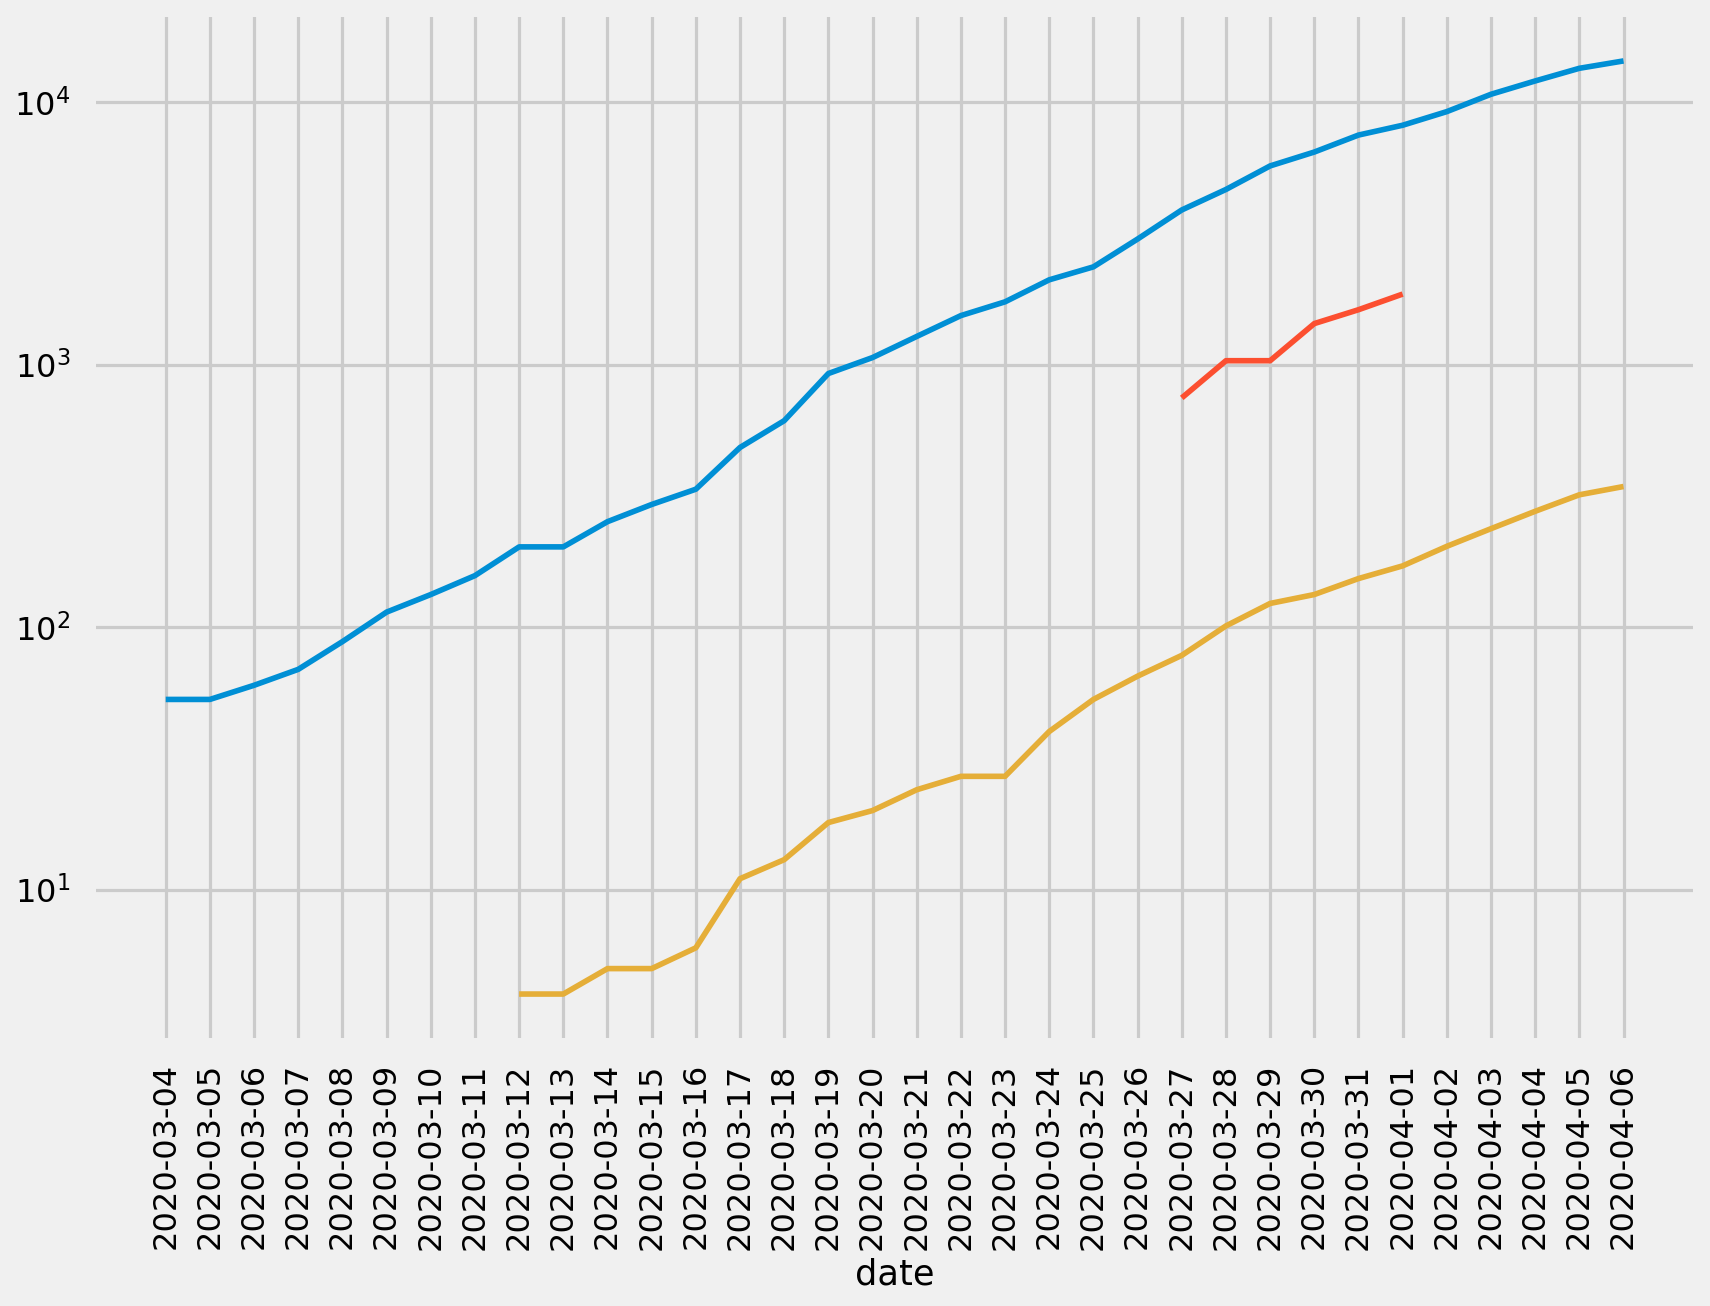

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

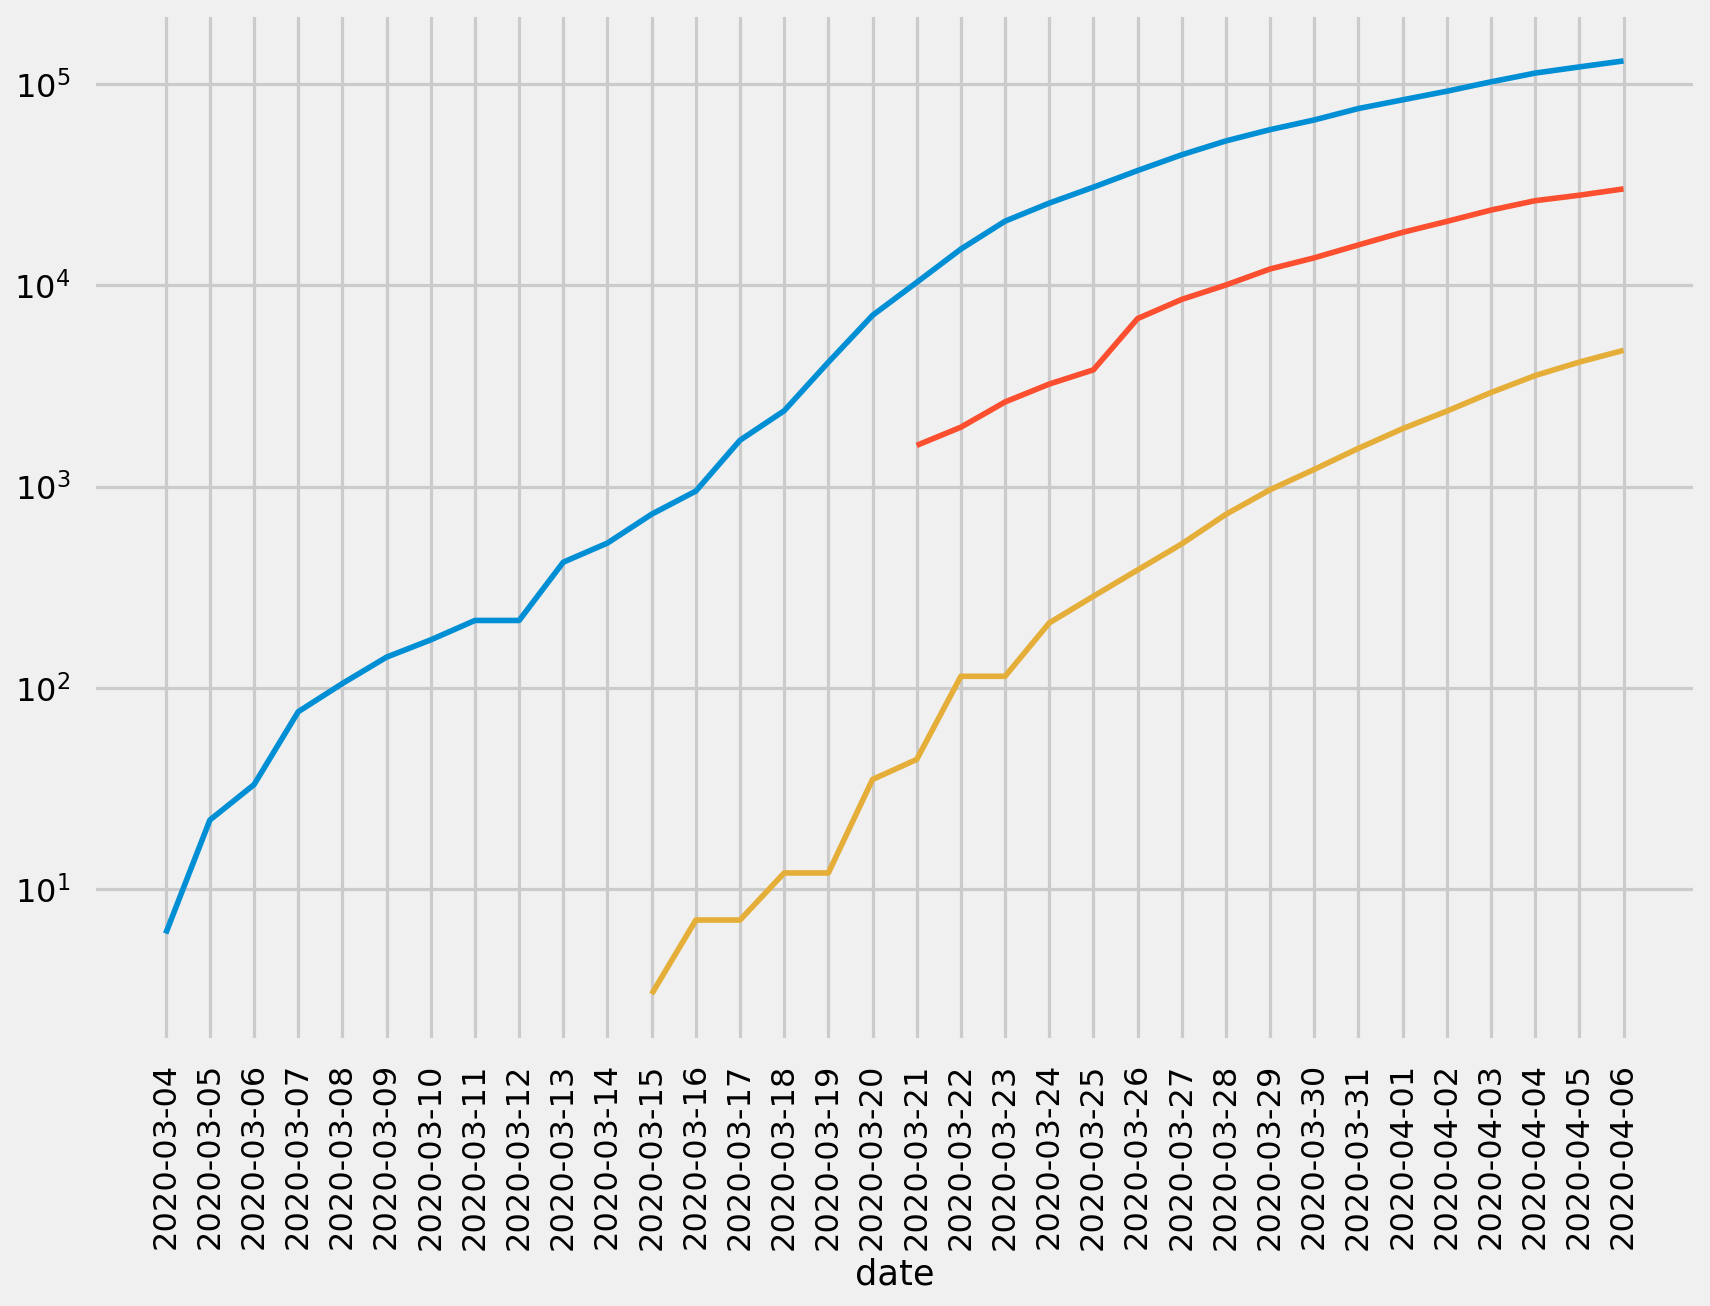

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'CA', 'WA', 'IL', 'MA', 'FL', 'GA']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1101,NY,4758.0
1003,NJ,1003.0
713,MI,727.0
584,LA,512.0
129,CA,343.0
1546,WA,338.0
454,IL,307.0
615,MA,260.0
292,FL,236.0
326,GA,229.0


In [18]:
# Deaths per million people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1101,NY,243.472987
1003,NJ,112.588848
584,LA,109.871763
713,MI,72.729710
196,CT,57.660038
1546,WA,44.853814
615,MA,37.669427
1514,VT,36.723674
227,DC,34.165890
1287,RI,25.536382


# Deaths

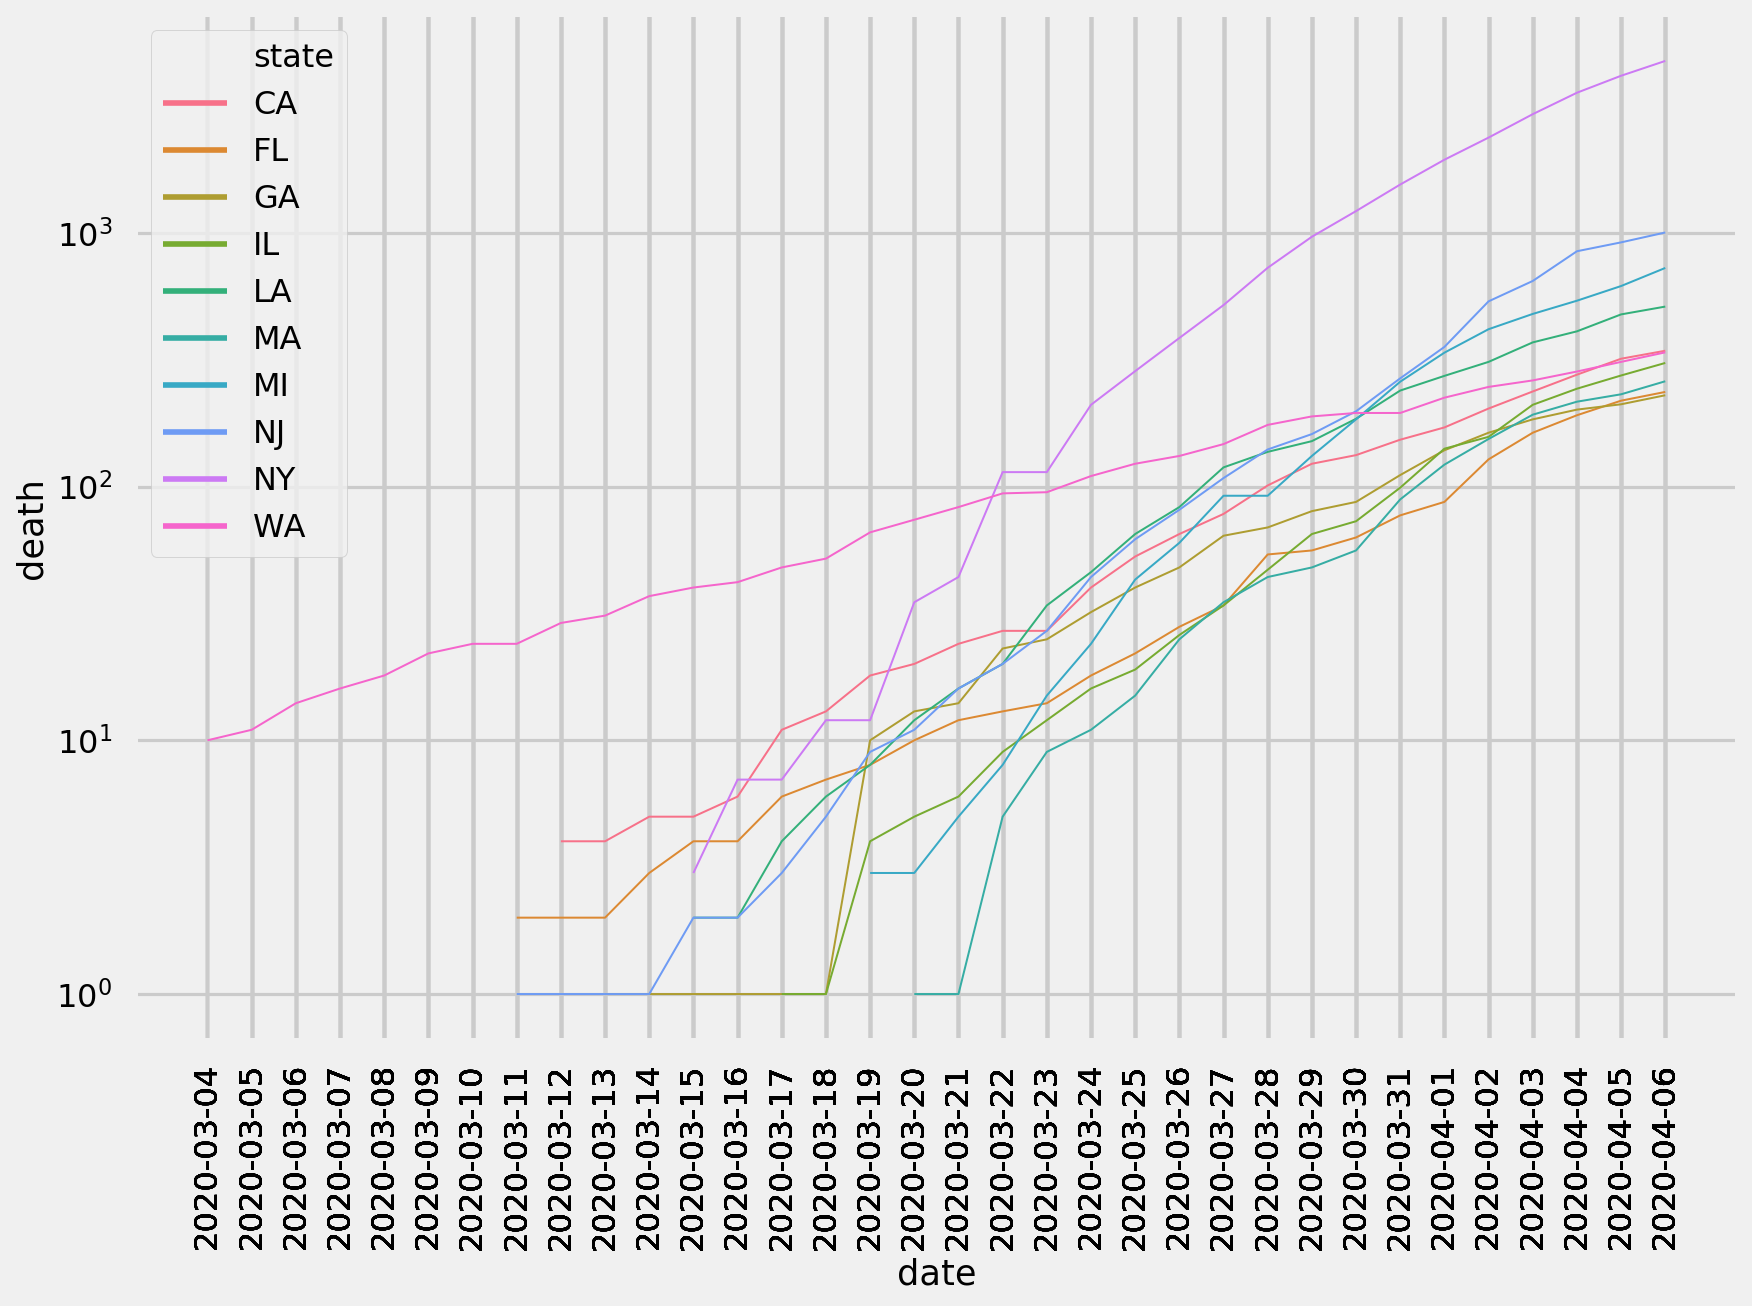

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

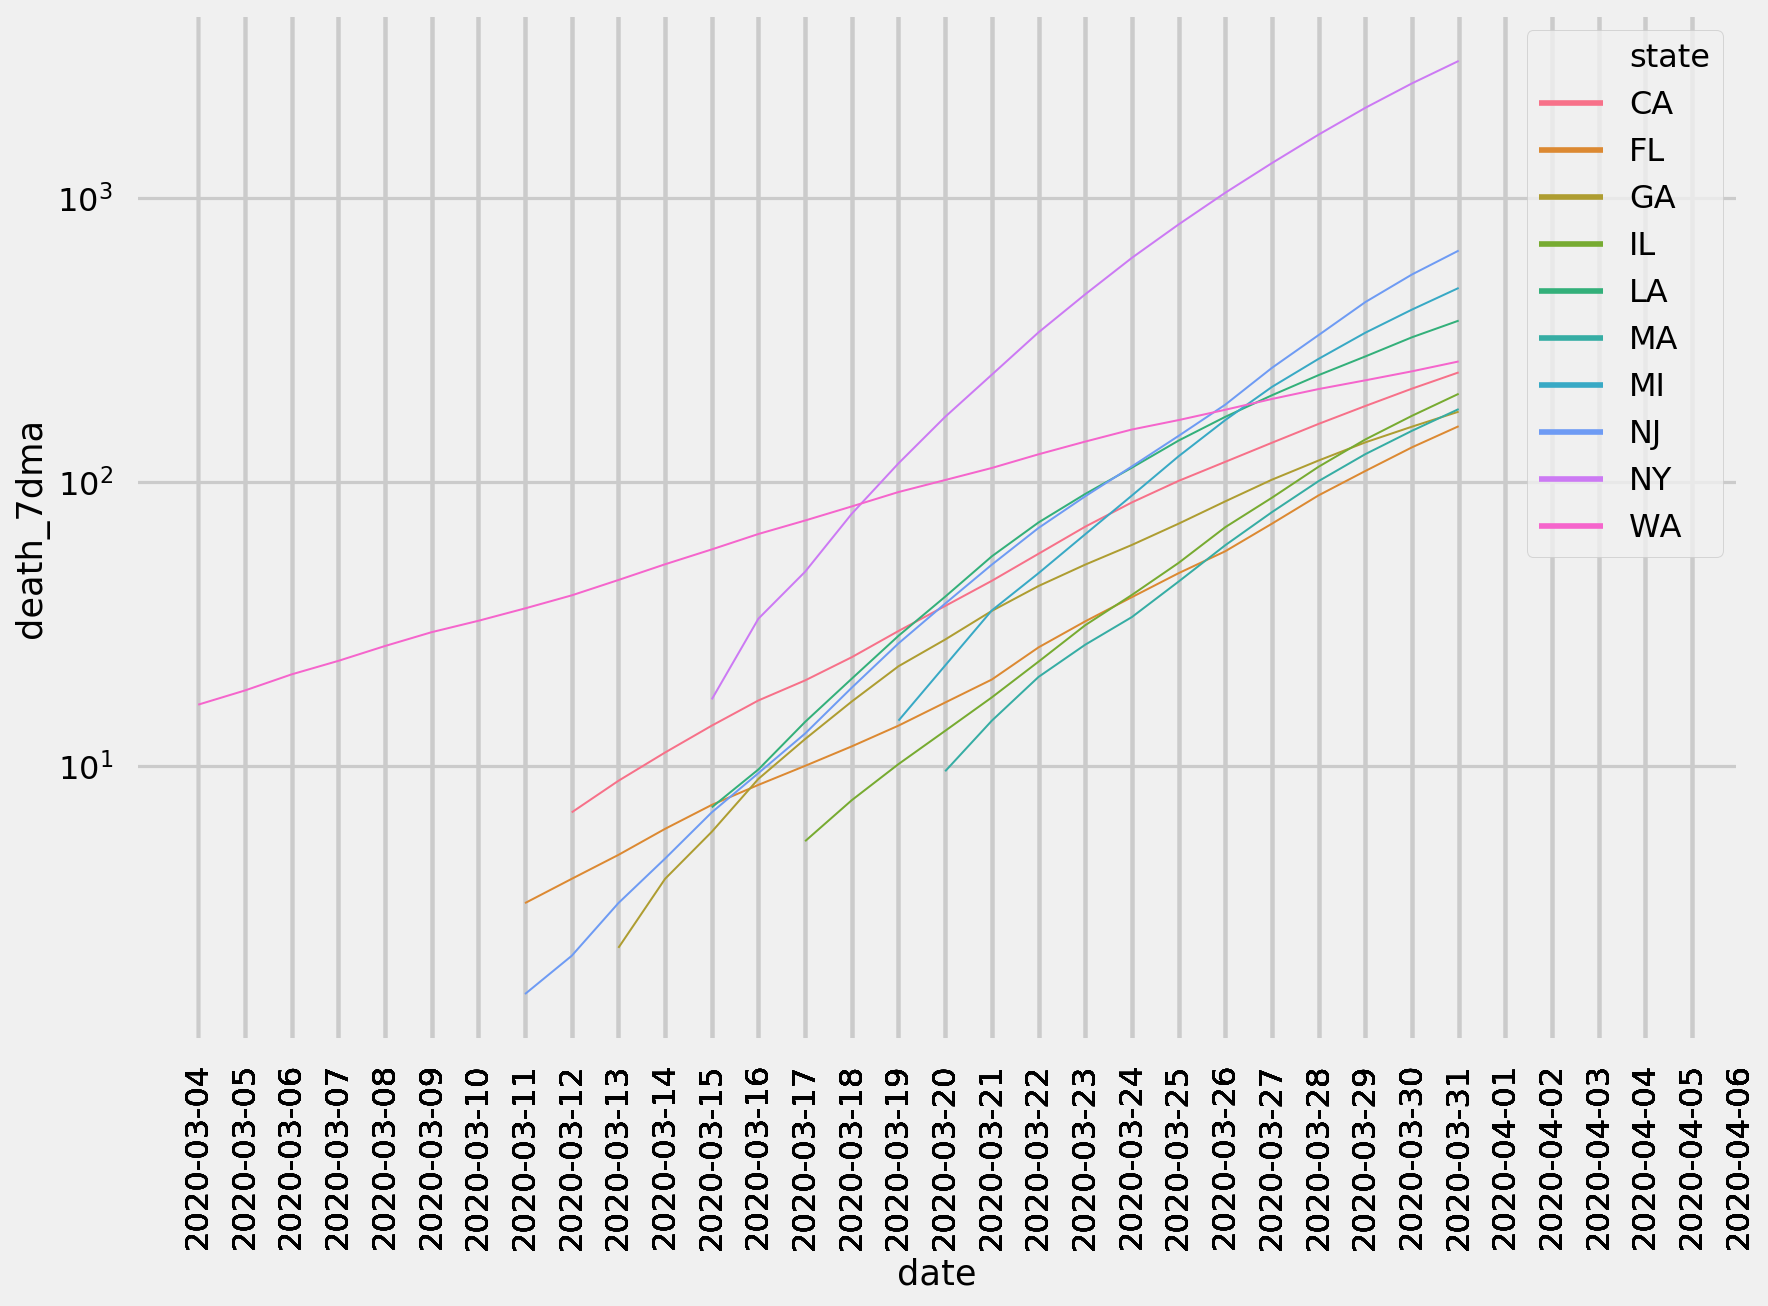

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per Million People

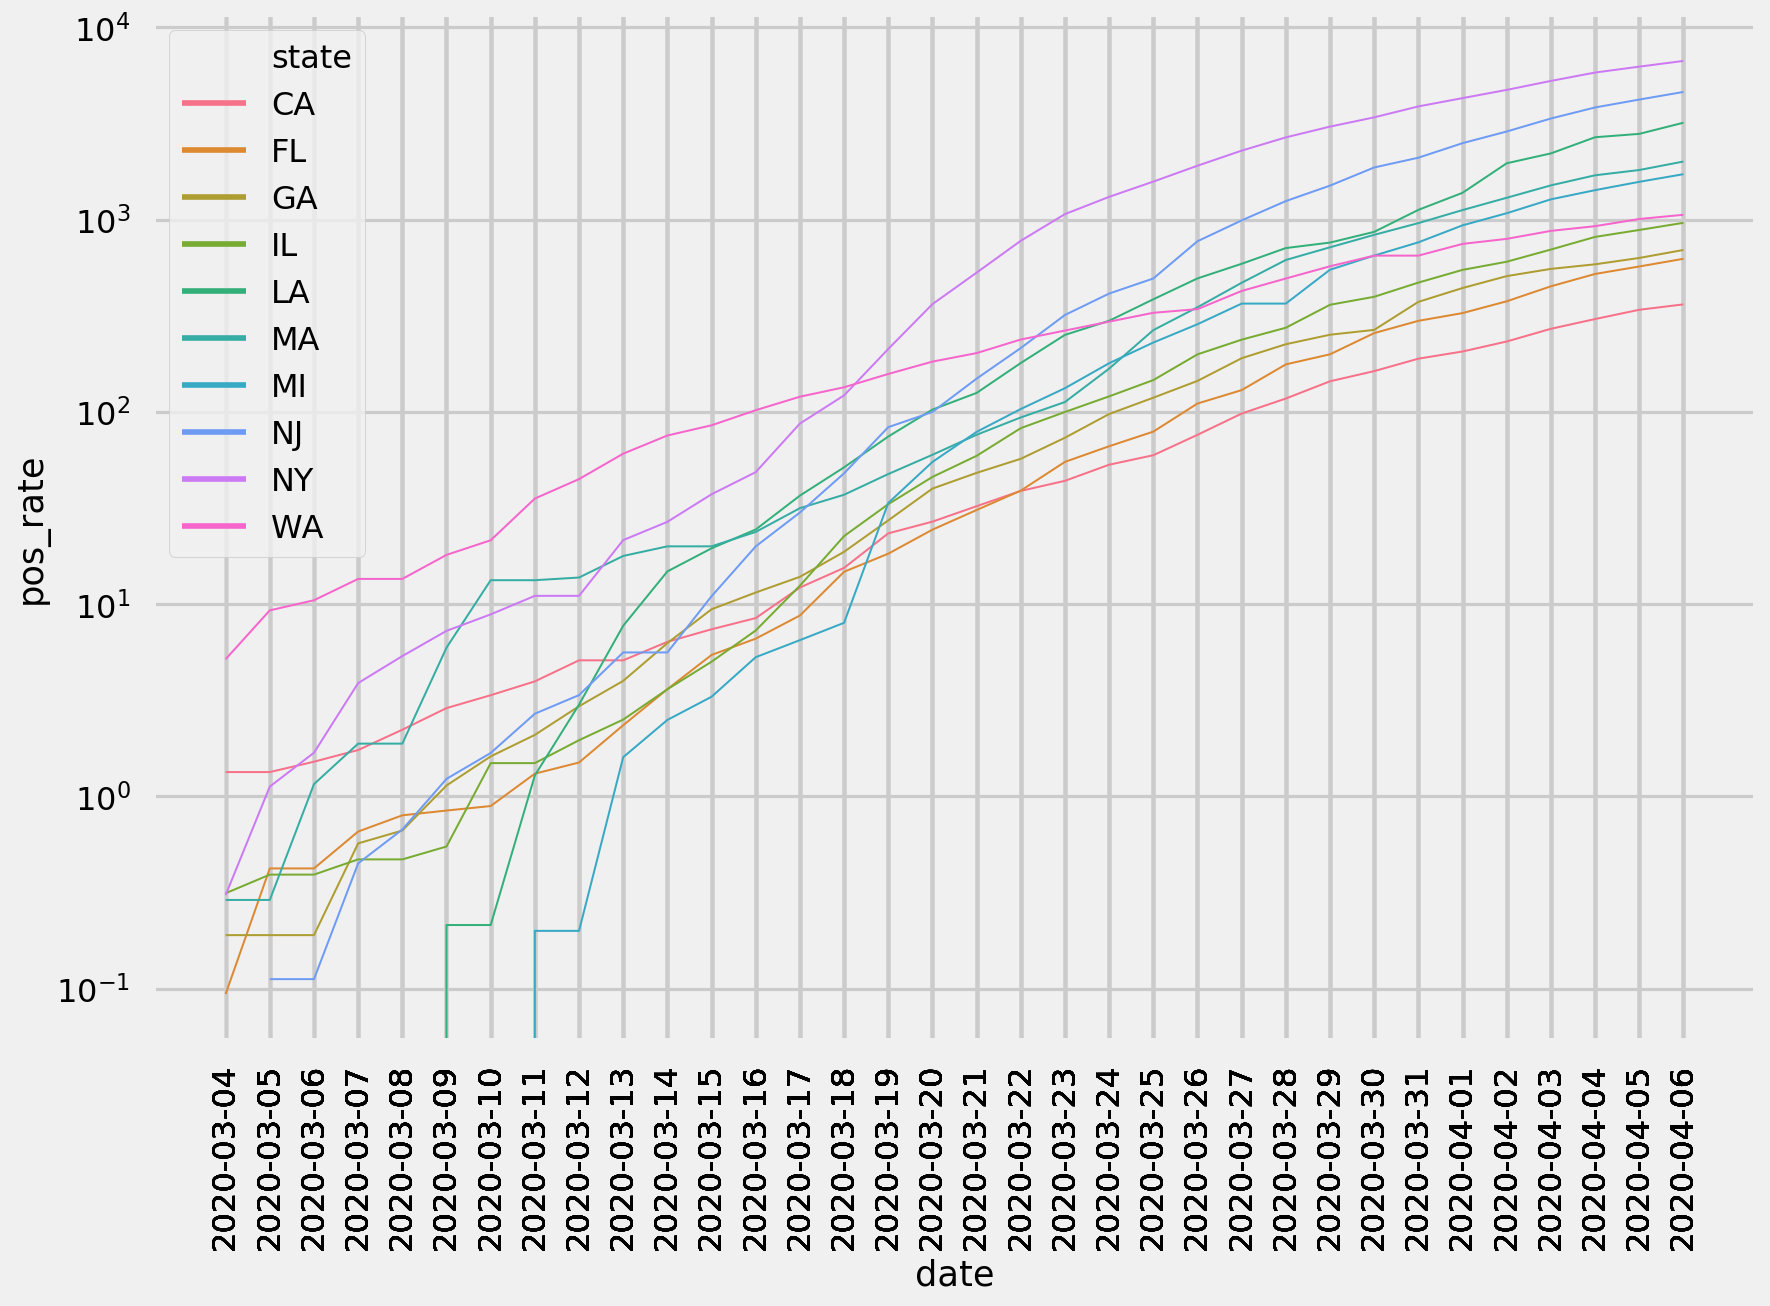

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Hospitalized Per Million People

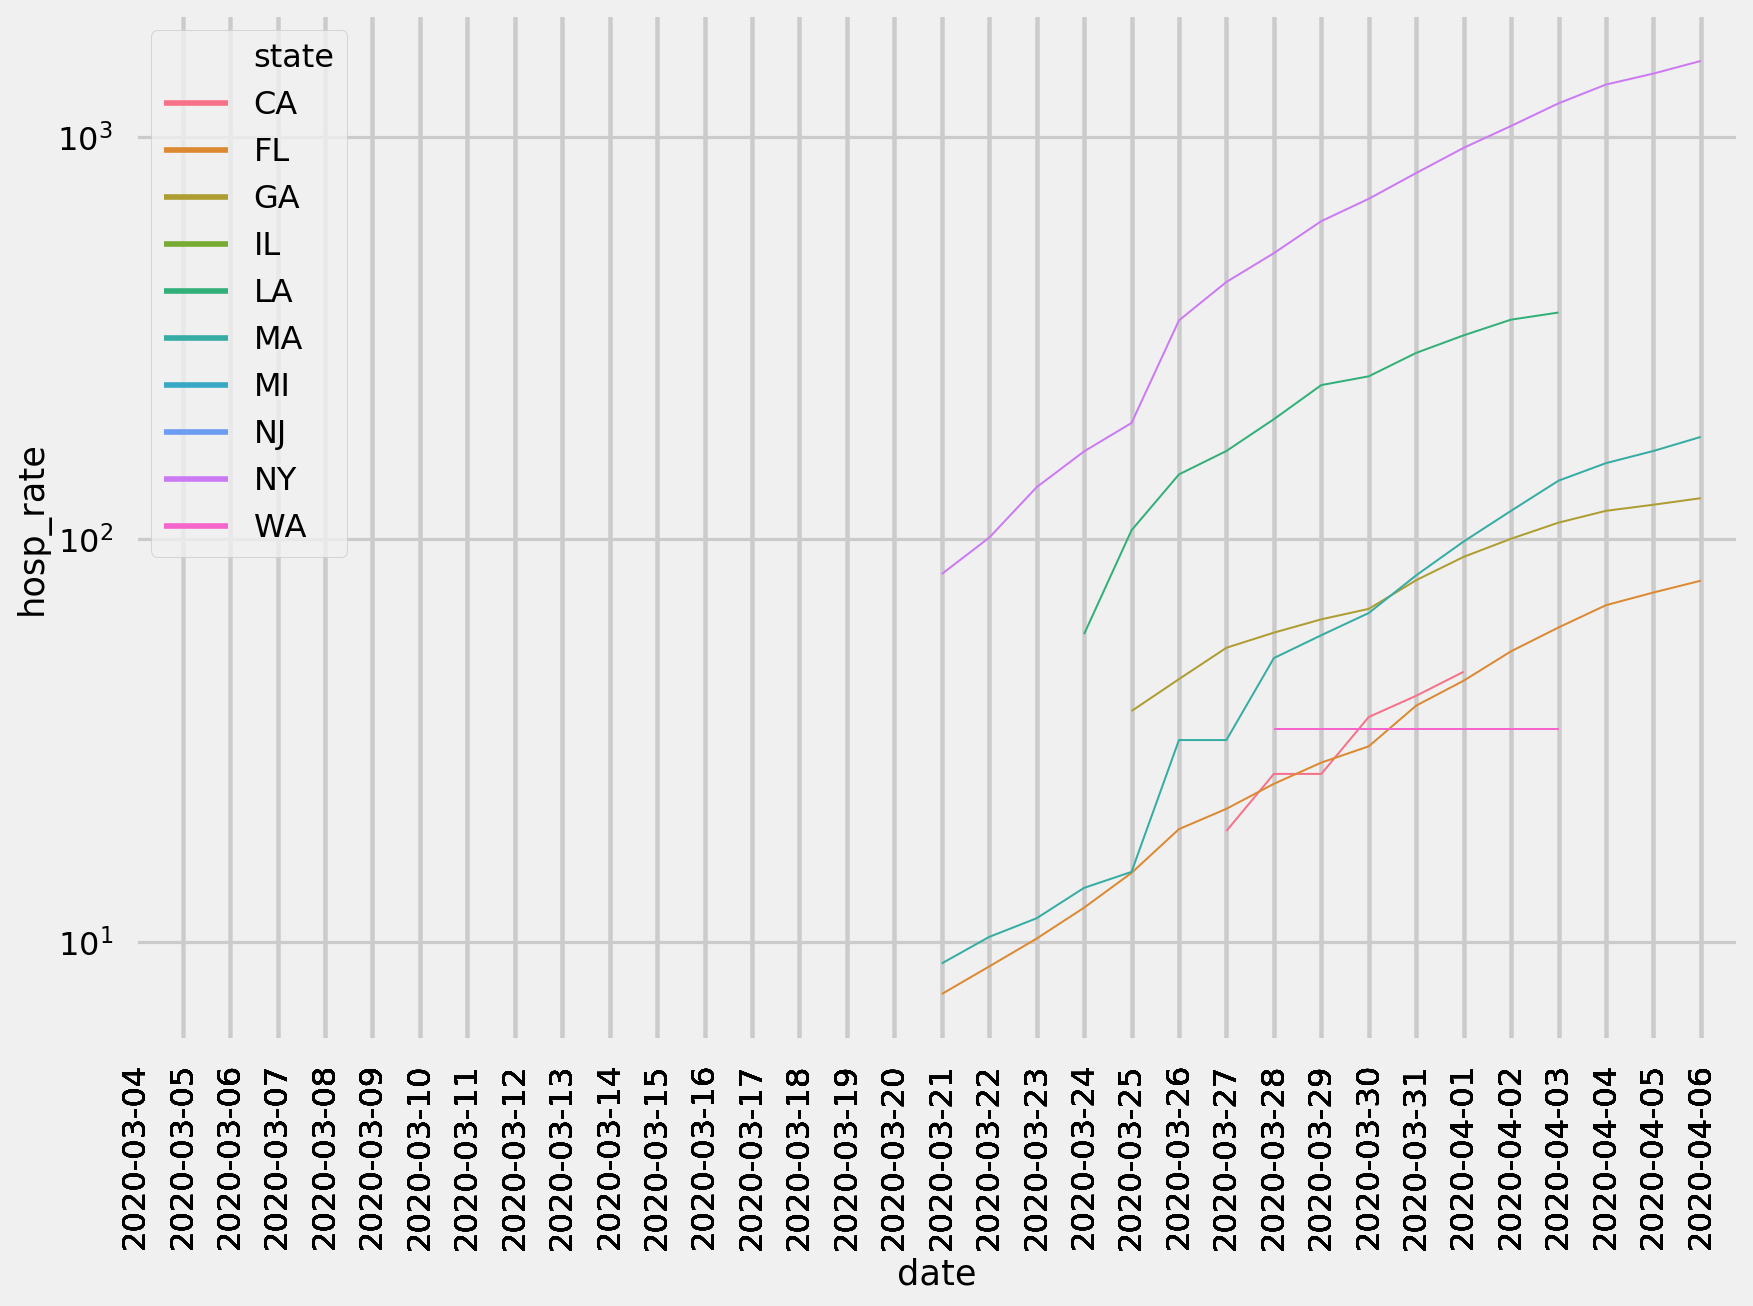

In [22]:
ax = sns.lineplot(x="date", y="hosp_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per Million People

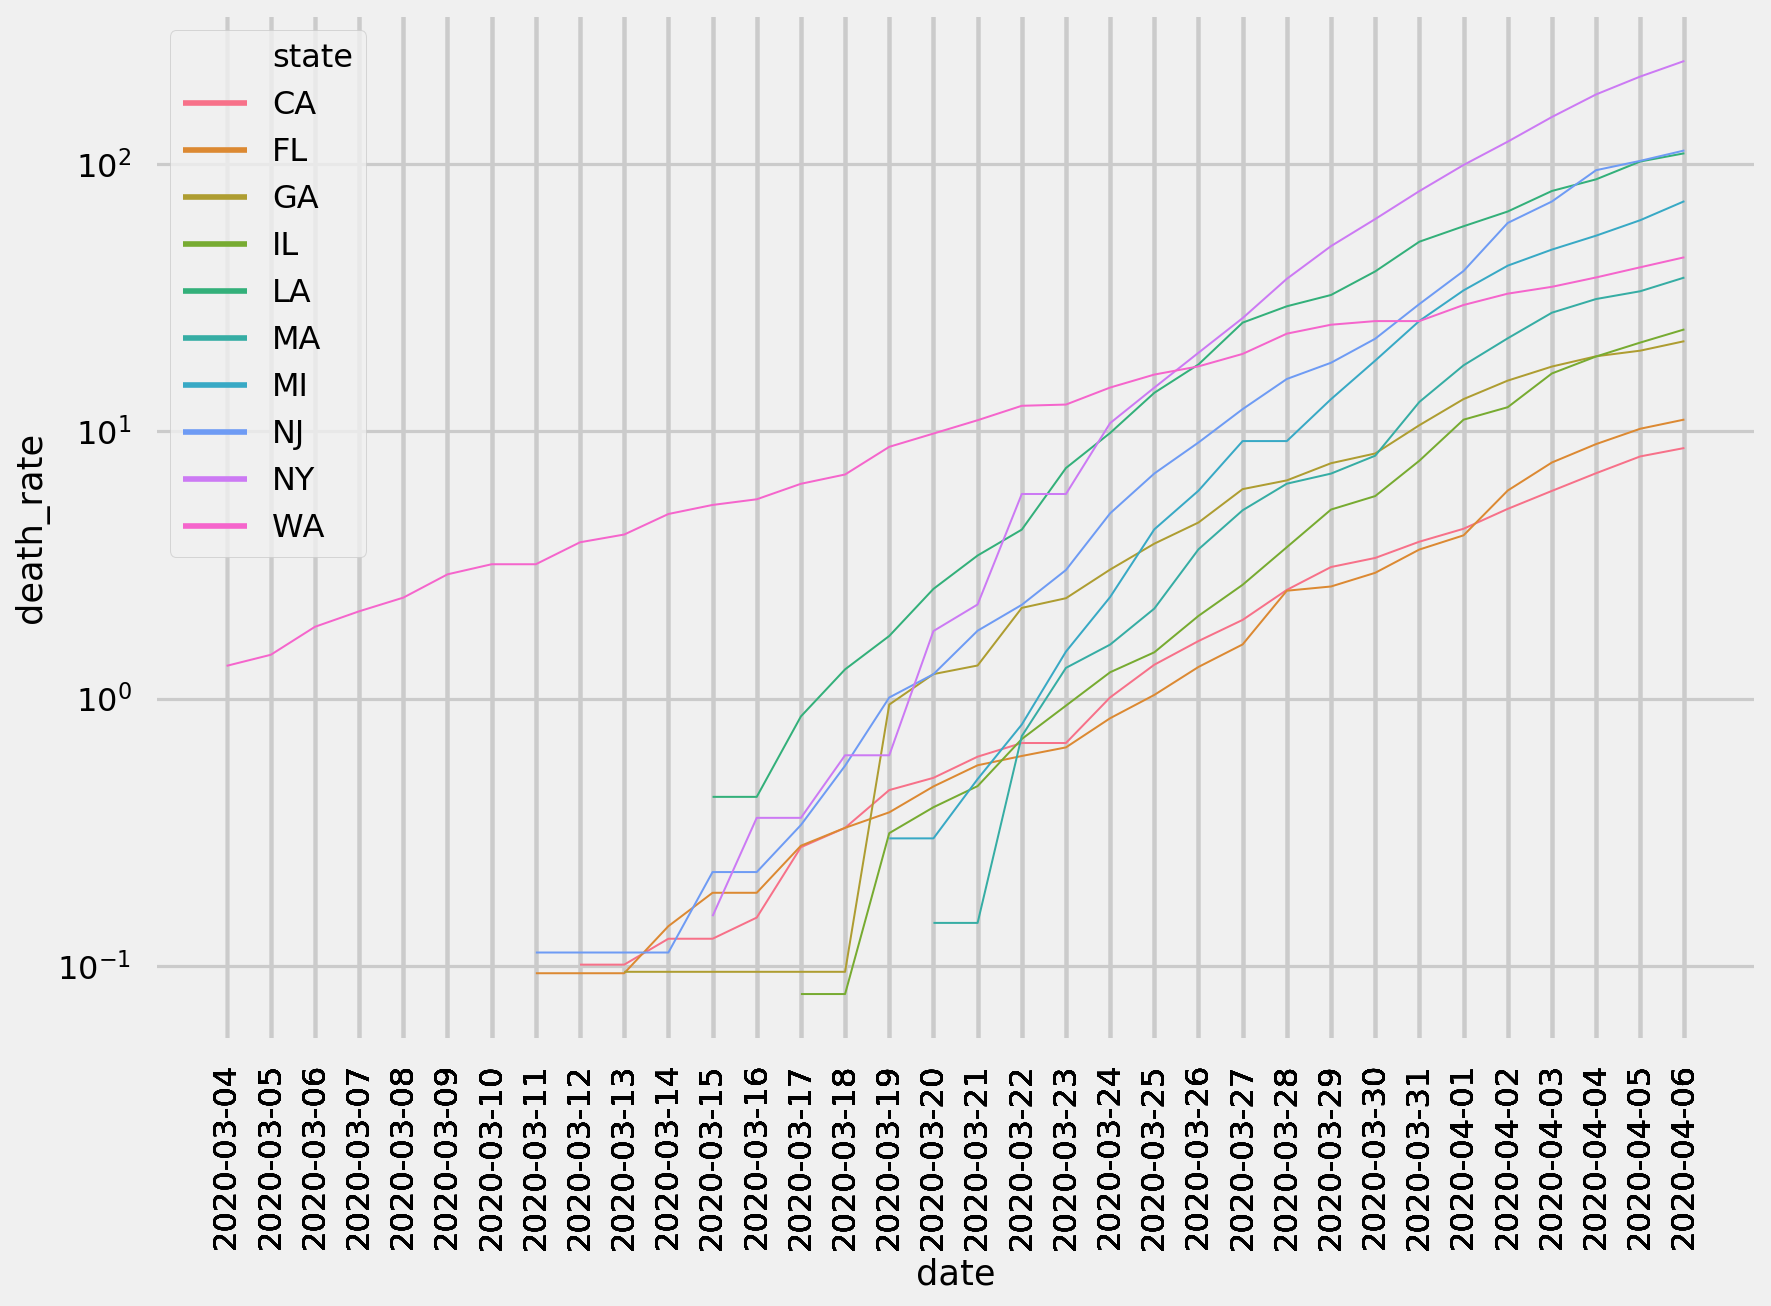

In [23]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per Million People

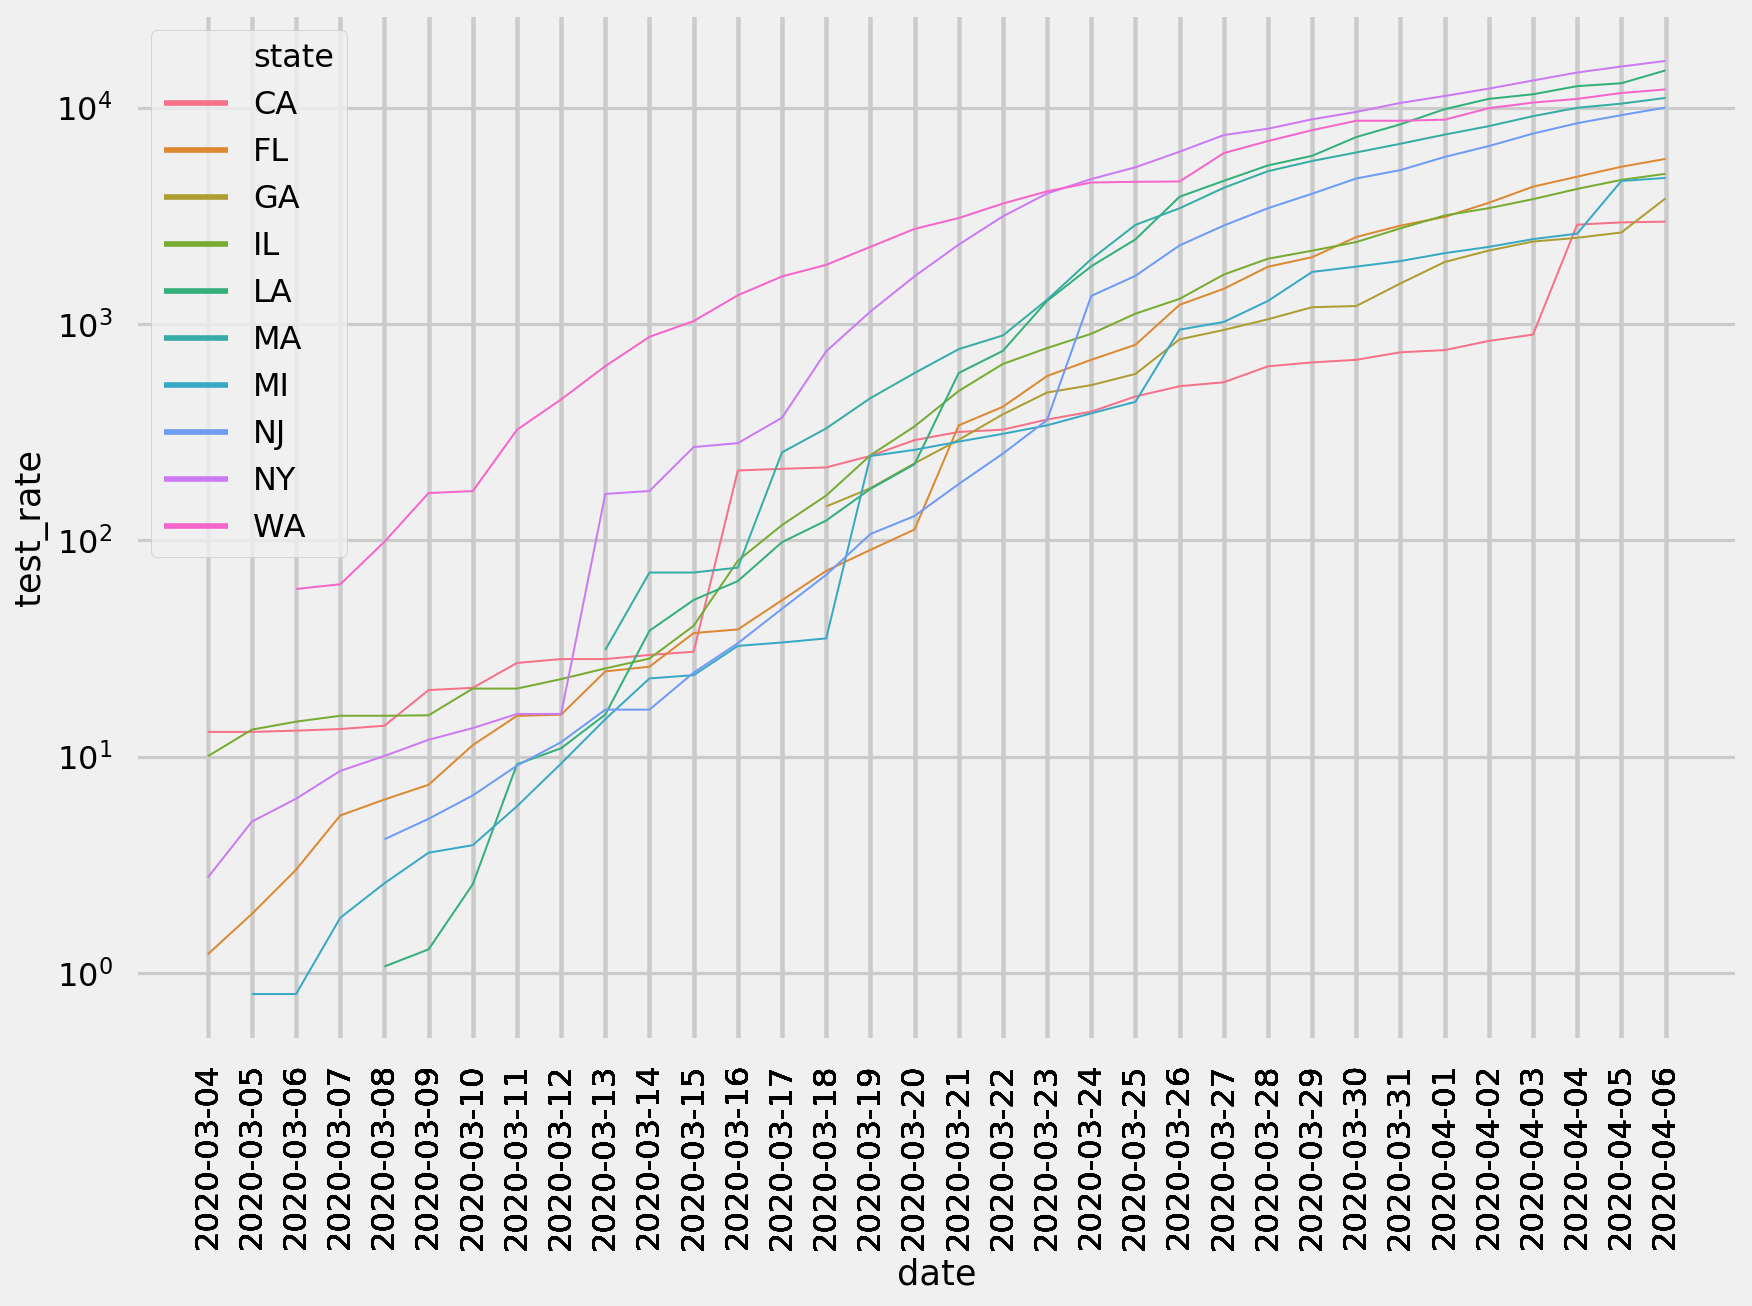

In [24]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [25]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1101,NY,16416.311994
584,LA,14842.559343
1546,WA,12125.790797
615,MA,11073.217921
227,DC,10609.932309
1514,VT,10590.788106
1450,UT,10564.027452
1003,NJ,9994.028189
360,HI,9522.059626
905,ND,9489.828004
